# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

from deap import algorithms, base, creator, tools

from sympy import *

sys.path.append('../promoter_solving/')
from promoter_solving_core import *

In [2]:
# Load csv with mRNA_ratio, MA_act, MA_inh
data = pd.read_csv('../data/pickle_dfs/zerod_M_MA_for_activator_inhibitor_and_mRNA_ratios_df.csv', index_col=0)
data.head()

,MA_activator,MA_inhibitor,actual_mRNA_ratio
control__wt_glc__1,0.019182,0.028499,2.186692
control__wt_glc__2,-0.019182,-0.028499,2.369230
fur__wt_dpd__1,-0.963901,-0.473642,0.490542
fur__wt_dpd__2,-1.116929,-0.541595,0.492320
fur__wt_fe__1,0.043720,-0.054857,1.756930


# Create Grids for Each Condition

In [3]:
grid = pd.DataFrame(columns = ['mRNA_ratio','grid'], index = data.index)
grid.loc[:,'mRNA_ratio'] = data.loc[:,'actual_mRNA_ratio']

In [4]:
equation = sympify('Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))')
equation

Eq(mRNARatio, (KdRNAP*cActivator + KdRNAPCrp)*(KdRNAP + KeqOpening*RNAP + RNAP)/(KdRNAP*KdRNAPCrp*(cActivator + cInhibitor + 1) + KdRNAP*RNAP*cActivator*(KeqOpening + 1) + KdRNAPCrp*RNAP*(KeqOpening + 1)))

In [5]:
# Define constants
constant_vals = {
    # NOTE: MAKE SURE TO UPDATE IF ANYTHING IS CHANGED
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    'KeqOpening': 10**-0.34444956947383365,
    'RNAP': 10**-6, 
}

input_range = {
    # 'cActivator': [0,1],
    'cInhibitor': [0,10], # Calculate cInhibitor values based on cActivator range
}

In [177]:
# Create lambda functions that we can plug in to
lambda_df = create_lambdas(equation, constant_vals)

# Parameter we are solving for using the other two
# solve = 'cInhibitor'
solve = 'cActivator'

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    working_grid = create_parameter_grid(num_steps = 1001, **input_range)

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(working_grid):
        # values['cActivator'] = pair[0]
        values['cInhibitor'] = pair[0]
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc[solve,'order']])
    
        # Evaluate the lambda function, order is currently (cActivator, cInhibitor)
        working_grid[ii] += ((lambda_df.loc[solve,'lambda'](values_tuple))[0],)
    
    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

In [178]:
grid.head()

,mRNA_ratio,grid
control__wt_glc__1,2.186692,"[(0.0, 0.06366081116826389), (0.01, 0.06468510..."
control__wt_glc__2,2.369230,"[(0.0, 0.07682301070769106), (0.01, 0.07798372..."
fur__wt_dpd__1,0.490542,"[(0.0, -0.019416192849881837), (0.01, -0.01925..."
fur__wt_dpd__2,0.492320,"[(0.0, -0.019354286677259695), (0.01, -0.01919..."
fur__wt_fe__1,1.756930,"[(0.0, 0.036804944072590995), (0.01, 0.0375508..."


# DEAP

In [179]:
creator.create(name = 'fitness',
               base = base.Fitness,
               weights = (1.0, -1.0,)) # Set to maximize dot product of MA_activator and cActivator, and minimize MA_inhibitor and cInhibitor

creator.create(name = 'individual',
               base = np.ndarray,
               fitness = creator.fitness)

toolbox = base.Toolbox()

/opt/miniconda3/envs/sym-seq-ml/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/miniconda3/envs/sym-seq-ml/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [180]:
random.seed(42)

def generate_individual(individual_class: type, data: pd.DataFrame):
    individual = individual_class(random.sample(grid,1)[0] for grid in grid['grid'])
    
    return individual

In [181]:
toolbox.register(alias = 'individual',
                 function = generate_individual,
                 individual_class = creator.individual,
                 data = grid)

toolbox.register('population',
                 tools.initRepeat,
                 list,
                 toolbox.individual)

In [182]:
test_population = toolbox.population(n=3)

In [183]:
MA_df

,MA_activator,MA_inhibitor
control__wt_glc__1,0.019182,0.028499
control__wt_glc__2,-0.019182,-0.028499
fur__wt_dpd__1,-0.963901,-0.473642
fur__wt_dpd__2,-1.116929,-0.541595
fur__wt_fe__1,0.043720,-0.054857
...,...,...
efeU__menFentCubiC_ale36__2,-0.194079,-0.128973
efeU__menFentCubiC_ale37__1,-0.178657,-0.057887
efeU__menFentCubiC_ale37__2,-0.161924,-0.092028
efeU__menFentCubiC_ale38__1,0.045234,-0.313445


In [214]:
# Evaluate
MA_df = data.iloc[:,0:2]

def objective(individual: object, MA_df: pd.DataFrame):
    unit_MA_activator = MA_df.loc[:,'MA_activator']/np.linalg.norm(MA_df.loc[:,'MA_activator'])
    unit_MA_inhibitor = MA_df.loc[:,'MA_inhibitor']/np.linalg.norm(MA_df.loc[:,'MA_inhibitor'])
    
    #NOTE: Need to swap 0 and 1 depending if calculating using cInhibitor or cActivator
    unit_ind_activator = individual[:,1]/np.linalg.norm(individual[:,1])
    unit_ind_inhibitor = individual[:,0]/np.linalg.norm(individual[:,0])
    
    activator_dot_product = np.dot(unit_MA_activator, unit_ind_activator)
    inhibitor_dot_product = np.dot(unit_MA_inhibitor, unit_ind_inhibitor)

    # sum_dot_product = np.sum(np.dot([-MA_df.iloc[:,1],MA_df.iloc[:,0]],individual[:]))
    """
    dot_product = []
    for i, _ in enumerate(MA_df.index):
        #dot_product.append((np.dot([MA_df.iloc[i,0],-MA_df.iloc[i,1]],individual[i]))**2) # If cActivator is used to calculate cInhibitor
        dot_product.append((np.dot([-MA_df.iloc[i,1],MA_df.iloc[i,0]],individual[i]))) # If cInhibotor is used to calculate cActivator
    sum_dots = np.sum(dot_product)
    """
    
    return activator_dot_product, inhibitor_dot_product,

toolbox.register(alias = 'evaluate', function = objective, MA_df = MA_df)

In [215]:
toolbox.evaluate(test_population[0])

(0.0876418526731225, -0.43079565407543313)

In [216]:
# NOTE: Not sure what appropriate tournament size should be
toolbox.register("select", tools.selTournament, tournsize=5)

# NOTE: Using np.ndarray individuals requires a different method to compare individuals
hof = tools.HallOfFame(3, similar=np.array_equal)

In [217]:
# Mutation
def mutate(individual: object, prob: float, data: pd.DataFrame):
    for i, _ in enumerate(individual):
        if random.random() < prob:
            individual[i] = random.sample(grid.iloc[i,1],1)[0]

    return individual,

mt_prob = 0.1  #NOTE: CHANGE ME
toolbox.register('mutate', function = mutate, prob = mt_prob, data = data)

In [218]:
# Crossover
def crossover(ind_one: object, ind_two: object, prob: float,):

    for i, _ in enumerate(ind_one):
        if random.random() < prob:
            ind_one[i], ind_two[i] = ind_two[i].copy(), ind_one[i].copy()

    return ind_one, ind_two

cx_prob = 0.1 # NOTE: CHANGE ME

toolbox.register(alias = "mate", function = crossover, prob = cx_prob,)

In [219]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [244]:
nind = 1000
mu = 500
lambda_ = 500
cxpb = 0.4
mutpb = 0.2
ngen = 10000

pop, logbook = algorithms.eaMuCommaLambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, 
            cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats, halloffame=hof, verbose=False)

In [246]:
toolbox.evaluate(hof[0])

(0.25735149727805395, -0.5711619738100538)

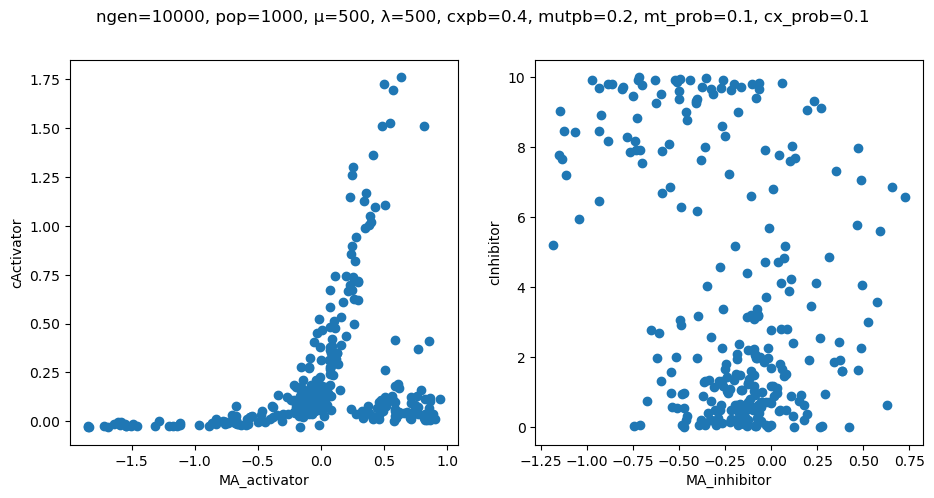

In [255]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), squeeze= True)
title = 'ngen='+str(ngen)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.set_xlabel('MA_activator')
ax2.set_xlabel('MA_inhibitor')
ax1.set_ylabel('cActivator')
ax2.set_ylabel('cInhibitor')
"""
# If cActivator is used to calculate cInhibitor
ax1.scatter(MA_df.iloc[:,0], hof[0][:,0])
ax2.scatter(MA_df.iloc[:,1], hof[0][:,1])
"""
# If cInhibitor is used to calculate cActivator
ax1.scatter(MA_df.iloc[:,0], hof[0][:,1])
ax2.scatter(MA_df.iloc[:,1], hof[0][:,0])